In [23]:
import pandas as pd
import wandb

import seaborn as sns
import numpy as np
import os

import matplotlib.pyplot as plt
sns.set_style("white", {"grid.color": ".6", "grid.linestyle": ":"})

In [24]:
pd.set_option('display.max_rows', 100)

In [25]:
from  matplotlib.colors import LinearSegmentedColormap

c = ["darkred", "firebrick", "red", "lightcoral", "palegreen", "lime", "green","darkgreen"]

v = [0,.15, 0.25,.4,0.65,0.85,.995,1.]
l = list(zip(v,c))

CMAP = LinearSegmentedColormap.from_list('rg',l, N=256)

---

In [26]:
# Чтобы выбрать долгие FID запуски надо: df["_runtime"] > 7200

def get_runs_df(project, entity="jurujin", resolution=False):
    '''
    Returns df with data from wandb project
    '''
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        name_list.append(run.name)


    summary_df = pd.DataFrame(summary_list)
    config_df = pd.DataFrame(config_list)

    df = pd.concat([summary_df.reset_index(drop=True), config_df.reset_index(drop=True)], axis=1)
    df["name"] = name_list
    if resolution:
        df["det_resol"] = df["no_w_det_dist_mean"] - df["w_det_dist_mean"]

    return df.sort_values(by=["w_radius", "msg_scaler"])

In [27]:
def get_runs_df_stable_sig(project, entity="jurujin"):
    '''
    Returns df with data from wandb project for stable-sig
    '''
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        name_list.append(run.name)


    summary_df = pd.DataFrame(summary_list)
    config_df = pd.DataFrame(config_list)

    df = pd.concat([summary_df.reset_index(drop=True), config_df.reset_index(drop=True)], axis=1)
    df["name"] = name_list

    return df

In [28]:
detection_projects = [
    "msg_long_detect_no_att",
    "msg_long_diff_att",     # V

    "msg_grid_srch_vae",    # V
    "msg_grid_srch_no_vae",

    "detect_msg_all_att_vae",
    "detect_msg_all_att_no_vae",
]

stable_signature_detection_projects = [
    "eval_stable_tree_all_attacks"
]

fid_projects = [
    "fid_msg_grid_srch_gen_vae",
    "fid_msg_grid_srch_gt_vae",  

    "fid_msg_grid_srch_gen_no_vae",
    "fid_msg_grid_srch_gt_no_vae",  

    "fid_msg_r_gen",
    "fid_msg_r_gt"

]

fid_att_projects = [
    "fid_gt_msg_all_att_vae",
    "fid_gt_msg_all_att_no_vae",

    "fid_gen_msg_all_att_vae",
    "fid_gen_msg_all_att_no_vae"
]

detection_cols = [
    "name",
    "TPR@1%FPR", "acc", "auc",
    "Bit_acc", "Word_acc",
    "det_resol",

    "w_clip_score_mean",

    "w_det_dist_mean",
    "no_w_det_dist_mean",

    "w_det_dist_std",
    "no_w_det_dist_std",
    
    "msg", "w_radius", "msg_scaler",

    "jpeg_ratio", "crop_scale", "crop_ratio", "gaussian_blur_r", "gaussian_std", "brightness_factor", "r_degree"
]

stable_signature_detection_cols = [
    "Bit_acc", "Word_acc"
]

fid_cols = [
    "name",
    "psnr_w", "ssim_w",
    "psnr_no_w", "ssim_no_w",
    "fid_w", "fid_no_w",
    "msg", "w_radius", "msg_scaler",

]

fid_att_cols = [
    "name",
    "psnr_w", "ssim_w",
    "psnr_no_w", "ssim_no_w",
    "fid_w", "fid_no_w",
    "msg", "w_radius", "msg_scaler",

    "jpeg_ratio", "crop_scale", "crop_ratio", "gaussian_blur_r", "gaussian_std", "brightness_factor", "r_degree"
]

In [29]:
os.makedirs("./detection", exist_ok=True)
os.makedirs("./fid", exist_ok=True)

In [30]:
for project in detection_projects:
    get_runs_df(project, resolution=True).to_csv(f"./detection/{project}.csv", index=False, columns=detection_cols)

for project in fid_projects:
    get_runs_df(project).to_csv(f"./fid/{project}.csv", index=False, columns=fid_cols)
    
for project in fid_att_projects:
    get_runs_df(project).sort_values(by=["jpeg_ratio"], na_position='first').to_csv(f"./fid/{project}.csv", index=False, columns=fid_att_cols)

for project in stable_signature_detection_projects:
    get_runs_df_stable_sig(project).to_csv(f"./detection/{project}.csv", index=False, columns=stable_signature_detection_cols)

---
## Plotting grid search tests:

In [31]:
def plot_grid_search(
    project,
    metric_name,
    figsize=(10, 8),
    x_ticks_step=5,
    y_ticks_step=10,
    azim=20,
    elev=45,
    zoom=0.95,
    reversed_cmap=False
    ):
    '''
    str metric_name: Name of the target column
    '''
    if reversed_cmap:
        cmap = CMAP.reversed()
    else:
        cmap = CMAP

    # df = get_runs_df(project)
    if "fid" in project.split("_"):
        df = pd.read_csv(f'./fid/{project}.csv')
    else:
        df = pd.read_csv(f'./detection/{project}.csv')

    scaler = df["msg_scaler"]
    radius = df["w_radius"]
    metric = df[metric_name]

    scaler_num = scaler.nunique()
    radius_num = radius.nunique()

    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(figsize, forward=True)

    # surf = ax.plot_surface(s, r, z, linewidth=0, antialiased=False)

    X = radius.values.reshape(radius_num, scaler_num)
    Y = scaler.values.reshape(radius_num, scaler_num)
    Z = metric.values.reshape(radius_num, scaler_num)

    surf = ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.8)

    ax.set_xlabel('Radius', fontsize=12)
    ax.set_ylabel('Scaler', fontsize=12)
    ax.set_zlabel(metric_name.replace("_", " "), fontsize=12)

    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect(zoom=zoom, aspect=None)

    ax.scatter(radius, scaler, metric, s=50, c="black", alpha=0.5)

    plt.xticks(np.arange(0, np.max(X) + x_ticks_step, x_ticks_step))
    plt.yticks(np.arange(np.min(Y), np.max(Y) + y_ticks_step, y_ticks_step))

    # Add color bar
    fig.colorbar(surf, shrink=0.4, aspect=8)


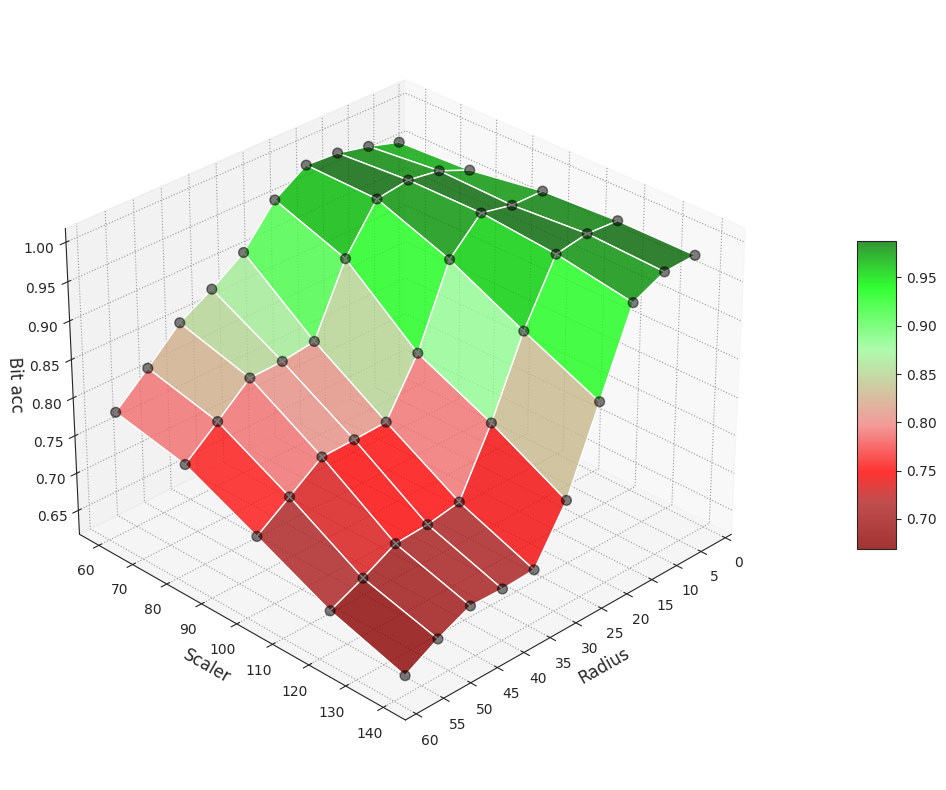

In [32]:
plot_grid_search(
    "msg_grid_srch_vae",
    metric_name="Bit_acc",
    elev=30,
    azim=45,
    figsize=(20, 10)
)

# plt.savefig("bit_acc_grid.png", bbox_inches='tight'))

In [33]:
def grid_search_table(
    project, metric_name, figsize=(10, 8),
    use_title=True, reversed_cmap=False,
    use_colorbar=True, float_signs=3,
    fontsize_label=14, fontsize_ticks=12
    ):
    '''
    str metric_name: Name of the target column
    '''

    if reversed_cmap:
        cmap = CMAP.reversed()
    else:
        cmap = CMAP

    # df = get_runs_df(project)
    if "fid" in project.split("_"):
        df = pd.read_csv(f'./fid/{project}.csv')
    else:df = pd.read_csv(f'./detection/{project}.csv')


    scaler = df["msg_scaler"]
    radius = df["w_radius"]
    metric = df[metric_name]

    scaler_num = scaler.nunique()
    radius_num = radius.nunique()

    
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize, forward=True)

    # surf = ax.plot_surface(s, r, z, linewidth=0, antialiased=False)

    X = radius.values.reshape(radius_num, scaler_num)
    Y = scaler.values.reshape(radius_num, scaler_num)
    Z = metric.values.reshape(radius_num, scaler_num)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    table = plt.pcolor(X, Y, Z, cmap=cmap, alpha=0.7)

    for i in range(radius_num):
        for j in range(scaler_num):
            plt.text(X[i, j], Y[i, j], f'{Z[i, j]:.{float_signs}f}', ha='center', va='center', color='black')

    plt.xticks(radius.unique(), fontsize=fontsize_ticks)
    plt.yticks(scaler.unique(), fontsize=fontsize_ticks)

    ax.set_xlabel('Radius', fontsize=fontsize_label)
    ax.set_ylabel('Scaler', fontsize=fontsize_label)

    if use_colorbar:
        fig.colorbar(table)

    name = metric_name.replace("_", " ")

    if "fid" in project.split("_"):
        name = name.split(" ")[0].upper()
        if "gt" in project.split("_"):
            name += " gt"
        else:
            name += " gen"

    if "no" in project.split("_"):
        name += ", Default VAE"
    else:
        name += ", Stable Signature VAE"
    
    if use_title:
        fig.suptitle(f'{name}', x=0.43, fontsize=18, y=0.95)

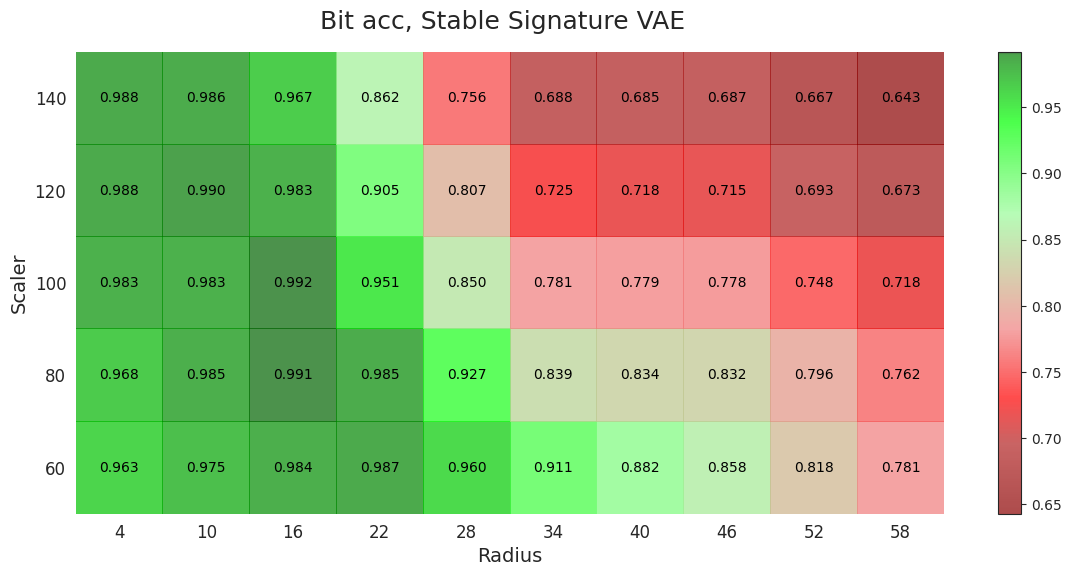

In [34]:
grid_search_table(
    "msg_grid_srch_vae",
    metric_name="Bit_acc",
    figsize=(14, 6)
)

# plt.savefig("bit_acc_grid.png", bbox_inches='tight')

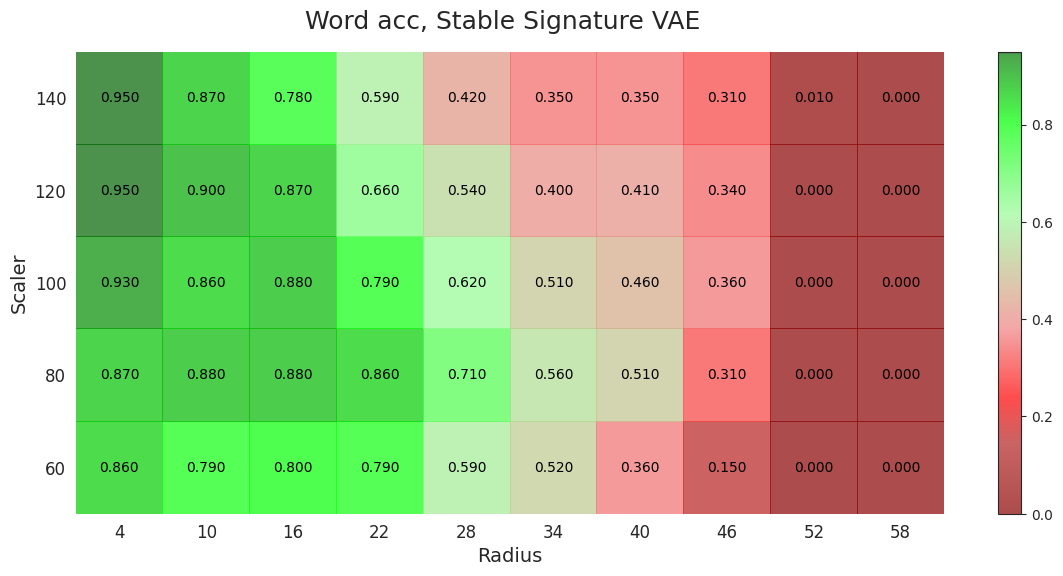

In [35]:
grid_search_table(
    "msg_grid_srch_vae",
    metric_name="Word_acc",
    figsize=(14, 6)
)

# plt.savefig("bit_acc_grid.png", bbox_inches='tight')

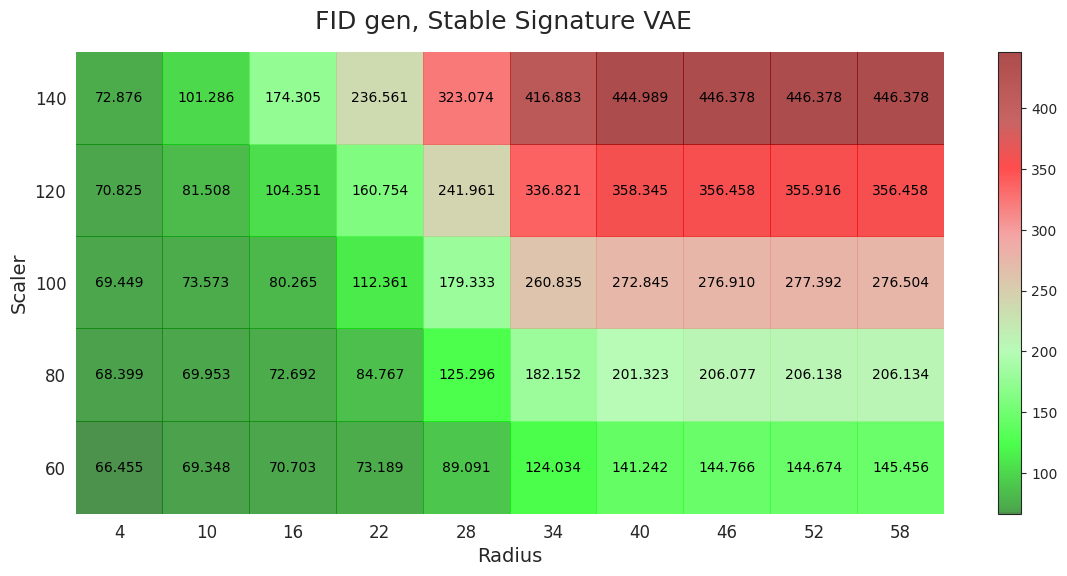

In [36]:
grid_search_table(
    "fid_msg_grid_srch_gen_vae",
    metric_name="fid_w",
    figsize=(14, 6),
    reversed_cmap=True
)

# plt.savefig("bit_acc_grid.png", bbox_inches='tight')

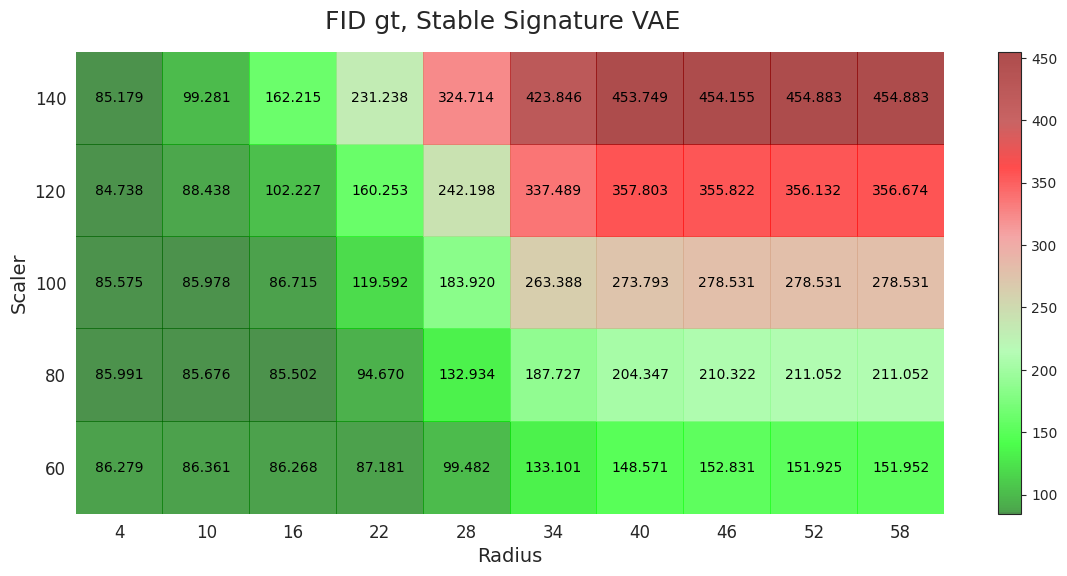

In [37]:
grid_search_table(
    "fid_msg_grid_srch_gt_vae",
    metric_name="fid_w",
    figsize=(14, 6),
    reversed_cmap=True
)

# plt.savefig("bit_acc_grid.png", bbox_inches='tight')

---
# Grid search Default VAE

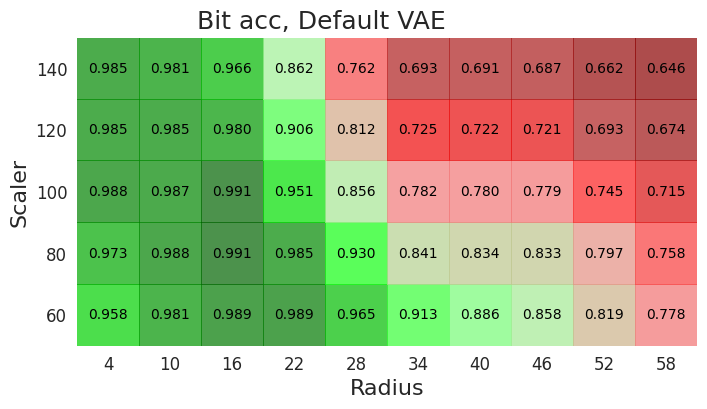

In [38]:
grid_search_table(
    "msg_grid_srch_no_vae",
    metric_name="Bit_acc",
    figsize=(8, 4),
    use_title=True,
    use_colorbar=False,
    fontsize_label=16,
    fontsize_ticks=12
)

plt.savefig("bit_acc_grid_default.png", bbox_inches='tight')

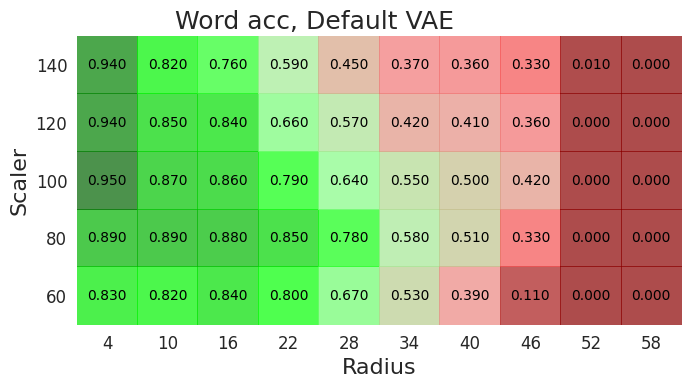

In [39]:
grid_search_table(
    "msg_grid_srch_no_vae",
    metric_name="Word_acc",
    figsize=(7.8, 3.75),
    use_title=True,
    use_colorbar=False,
    fontsize_label=16,
    fontsize_ticks=12
)

plt.savefig("word_acc_grid_default.png", bbox_inches='tight')

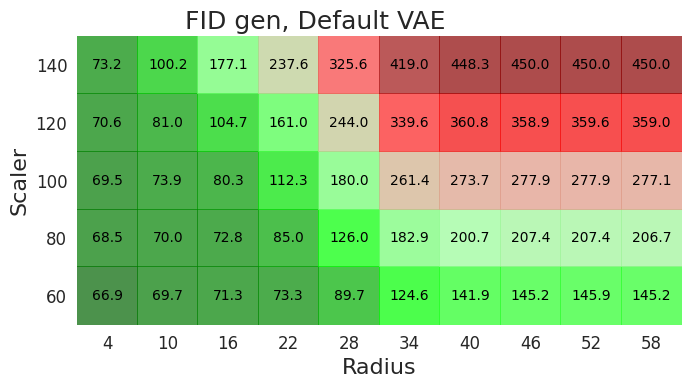

In [40]:
grid_search_table(
    "fid_msg_grid_srch_gen_no_vae",
    metric_name="fid_w",
    figsize=(7.8, 3.75),
    use_title=True,
    reversed_cmap=True,
    float_signs=1,
    use_colorbar=False,
    fontsize_label=16,
    fontsize_ticks=12
)

plt.savefig("fid_gen_grid_default.png", bbox_inches='tight')

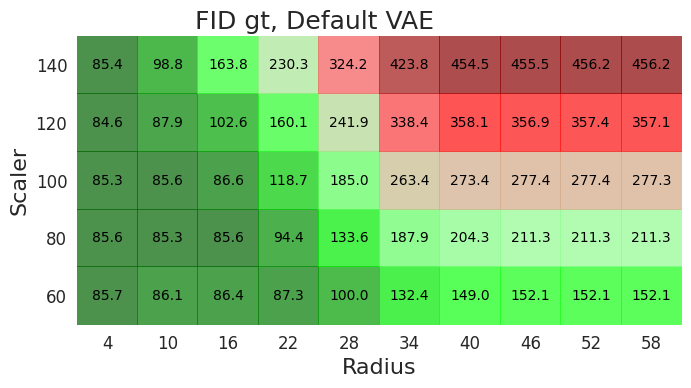

In [41]:
grid_search_table(
    "fid_msg_grid_srch_gt_no_vae",
    metric_name="fid_w",
    figsize=(7.8, 3.75),
    use_title=True,
    reversed_cmap=True,
    float_signs=1,
    use_colorbar=False,
    fontsize_label=16,
    fontsize_ticks=12
)

plt.savefig("fid_gt_grid_default.png", bbox_inches='tight')

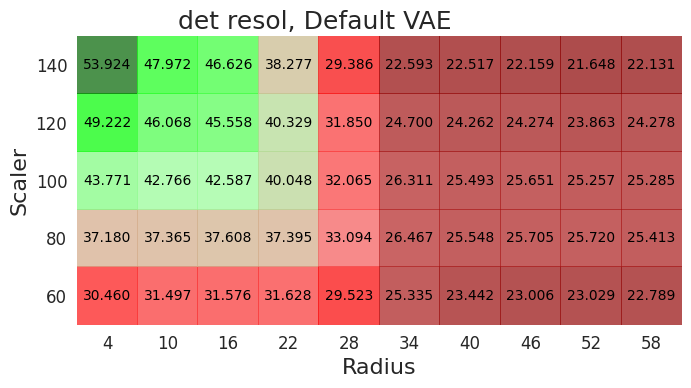

In [42]:
grid_search_table(
    "msg_grid_srch_no_vae",
    metric_name="det_resol",
    figsize=(7.8, 3.75),
    use_title=True,
    use_colorbar=False,
    fontsize_label=16,
    fontsize_ticks=12
)

plt.savefig("det_resol_grid_default.png", bbox_inches='tight')

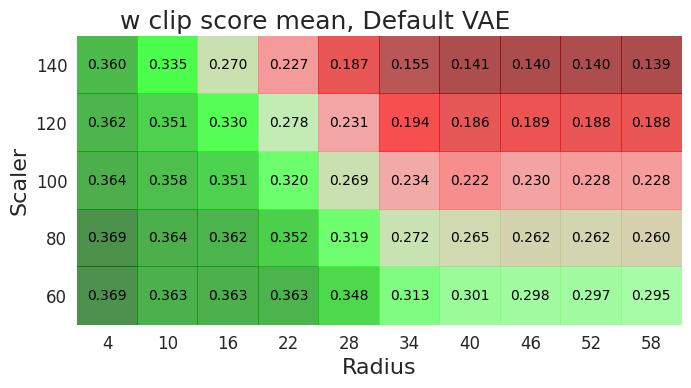

In [43]:
grid_search_table(
    "msg_grid_srch_no_vae",
    metric_name="w_clip_score_mean",
    figsize=(7.8, 3.75),
    use_title=True,
    use_colorbar=False,
    fontsize_label=16,
    fontsize_ticks=12
)

plt.savefig("w_clip_grid_default.png", bbox_inches='tight')